# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the Litecoin cryptocurrency and the minimum threshold is 0.5

In [ ]:
################# IMPORTS AND SETUP ##############################

from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
start = "1514761200" # 01.01.2018
periods = 88 # approx 8 years
TICKER = "LTCUSDT"
options = ["high", "low", "close"] # Available options: high, low, close, volume, diff, extreme --- diff = high + low, extreme = high - low
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR="LTCUSDT:high"
TIME = "LTCUSDT:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2017-12-31 23:00:00,226.44000000,227.22000000,222.53000000,223.69000000,1157.31361000
1,2018-01-01 00:00:00,223.69000000,223.69000000,217.25000000,219.98000000,978.11778000
2,2018-01-01 01:00:00,219.25000000,220.50000000,212.74000000,212.75000000,1165.80333000
3,2018-01-01 02:00:00,212.75000000,216.99000000,212.75000000,216.32000000,736.41344000
4,2018-01-01 03:00:00,215.71000000,220.99000000,215.20000000,218.12000000,1005.10601000
...,...,...,...,...,...,...
63256,2025-03-24 18:00:00,94.43000000,94.84000000,93.99000000,94.67000000,23153.27800000
63257,2025-03-24 19:00:00,94.67000000,95.00000000,94.47000000,94.56000000,19605.17300000
63258,2025-03-24 20:00:00,94.57000000,95.42000000,94.56000000,94.97000000,25546.68500000
63259,2025-03-24 21:00:00,94.98000000,95.60000000,94.55000000,94.93000000,28502.07800000


In [3]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": [], f"{TICKER}:diff": [], f"{TICKER}:extreme": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    high = percent_difference(float(o), float(raw_data["high"][i]))
    low = percent_difference(float(o), float(raw_data["low"][i]))

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(high) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(low) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:diff"].append(high + low) # difference between the high and low percentages
    processed_data[f"{TICKER}:extreme"].append(high - low) # difference between the high and low percentages

# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume", f"{TICKER}:diff", f"{TICKER}:extreme"])
display(processed_data)

,LTCUSDT:time,LTCUSDT:high,LTCUSDT:low,LTCUSDT:close,LTCUSDT:volume,LTCUSDT:diff,LTCUSDT:extreme
0,2018-01-01 00:00:00,0.000000,-2.878984,-1.658545,-15.483775,-2.878984,2.878984
1,2018-01-01 01:00:00,0.570125,-2.969213,-2.964652,19.188441,-2.399088,3.539339
2,2018-01-01 02:00:00,1.992949,0.000000,1.678026,-36.832104,1.992949,1.992949
3,2018-01-01 03:00:00,2.447731,-0.236429,1.117241,36.486647,2.211302,2.684159
4,2018-01-01 04:00:00,2.911242,0.000000,2.672841,-13.130611,2.911242,2.911242
...,...,...,...,...,...,...,...
63255,2025-03-24 18:00:00,0.434184,-0.465954,0.254157,24.030034,-0.031770,0.900138
63256,2025-03-24 19:00:00,0.348579,-0.211260,-0.116193,-15.324418,0.137319,0.559839
63257,2025-03-24 20:00:00,0.898805,-0.010574,0.422967,30.305838,0.888231,0.909379
63258,2025-03-24 21:00:00,0.652769,-0.452727,-0.052643,11.568597,0.200042,1.105496


In [ ]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
high_data_processed = processed_data["LTCUSDT:high"].to_list()

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in high_data_processed) / len(high_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in high_data_processed) / len(high_data_processed)}")
print("----------------------------------------------------------------------")

close_data_processed = processed_data["LTCUSDT:close"].to_list()

print(f"MAX CLOSE IN DATASET: {max(close_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 0.5 for x in close_data_processed) / len(close_data_processed)}")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in close_data_processed)}")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in close_data_processed)} - PERCENT OF DATASET: {sum(x > 1 for x in close_data_processed) / len(close_data_processed)}")

In [4]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,LTCUSDT:high0,LTCUSDT:low0,LTCUSDT:close0,LTCUSDT:high1,LTCUSDT:low1,LTCUSDT:close1,LTCUSDT:high2,LTCUSDT:low2,LTCUSDT:close2,...,LTCUSDT:high7,LTCUSDT:low7,LTCUSDT:close7,LTCUSDT:high8,LTCUSDT:low8,LTCUSDT:close8,LTCUSDT:high9,LTCUSDT:low9,LTCUSDT:close9,Label
0,2018-01-01 09:00:00,0.000000,-2.878984,-1.658545,0.570125,-2.969213,-2.964652,1.992949,0.000000,1.678026,...,0.039146,-2.222609,-2.096473,0.830631,-0.946120,-0.279838,1.554566,-0.258352,1.118040,1
1,2018-01-01 10:00:00,0.570125,-2.969213,-2.964652,1.992949,0.000000,1.678026,2.447731,-0.236429,1.117241,...,0.830631,-0.946120,-0.279838,1.554566,-0.258352,1.118040,0.546207,-0.880980,0.383226,0
2,2018-01-01 11:00:00,1.992949,0.000000,1.678026,2.447731,-0.236429,1.117241,2.911242,0.000000,2.672841,...,1.554566,-0.258352,1.118040,0.546207,-0.880980,0.383226,0.215007,-3.707767,-1.974550,0
3,2018-01-01 12:00:00,2.447731,-0.236429,1.117241,2.911242,0.000000,2.672841,0.723343,-0.549205,0.107162,...,0.546207,-0.880980,0.383226,0.215007,-3.707767,-1.974550,0.349760,-0.699520,-0.304919,1
4,2018-01-01 13:00:00,2.911242,0.000000,2.672841,0.723343,-0.549205,0.107162,2.952984,-0.388081,2.551521,...,0.215007,-3.707767,-1.974550,0.349760,-0.699520,-0.304919,0.792829,-2.432542,-1.346908,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63245,2025-03-24 17:00:00,1.024038,0.000000,0.873127,0.213744,-0.438175,-0.085497,0.502781,-0.096277,0.417202,...,0.673005,-0.384574,0.555496,0.318708,-0.849888,-0.350579,0.970046,-0.202537,0.650251,0
63246,2025-03-24 18:00:00,0.213744,-0.438175,-0.085497,0.502781,-0.096277,0.417202,0.138489,-0.607223,-0.159795,...,0.318708,-0.849888,-0.350579,0.970046,-0.202537,0.650251,0.434184,-0.465954,0.254157,0
63247,2025-03-24 19:00:00,0.502781,-0.096277,0.417202,0.138489,-0.607223,-0.159795,0.128027,-0.554785,-0.554785,...,0.970046,-0.202537,0.650251,0.434184,-0.465954,0.254157,0.348579,-0.211260,-0.116193,1
63248,2025-03-24 20:00:00,0.138489,-0.607223,-0.159795,0.128027,-0.554785,-0.554785,0.289700,-0.590129,0.257511,...,0.434184,-0.465954,0.254157,0.348579,-0.211260,-0.116193,0.898805,-0.010574,0.422967,1


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [5]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
LABEL = "Label"

# defining training data
new_labelled_dataframe = labelled_data_frame.copy()
new_labelled_dataframe = new_labelled_dataframe.reset_index(drop=True)
new_labelled_dataframe = new_labelled_dataframe.drop(columns=["time"])
#display(new_labelled_dataframe)

training_dataframe = new_labelled_dataframe.iloc[:-VALIDATION_SIZE].copy()
# display(training_dataframe)
train_tabular_dataset = TabularDataset(training_dataframe)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250401_105830"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.75 GB / 15.92 GB (36.1%)
Disk Space Avail:   133.66 GB / 475.69 GB (28.1%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [6]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = new_labelled_dataframe.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
# test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(testing_dataframe)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


{'accuracy': 0.6963,
 'balanced_accuracy': 0.6701181727027203,
 'mcc': 0.35211081943224,
 'roc_auc': 0.7382652441667386,
 'f1': 0.5867464961219213,
 'precision': 0.6388148148148148,
 'recall': 0.5425264217413186,
 'confusion_matrix':       0     1
 0  4807  1219
 1  1818  2156,
 'classification_report': {'0': {'precision': 0.7255849056603774,
   'recall': 0.7977099236641222,
   'f1-score': 0.7599399256975733,
   'support': 6026.0},
  '1': {'precision': 0.6388148148148148,
   'recall': 0.5425264217413186,
   'f1-score': 0.5867464961219213,
   'support': 3974.0},
  'accuracy': 0.6963,
  'macro avg': {'precision': 0.682199860237596,
   'recall': 0.6701181727027203,
   'f1-score': 0.6733432109097472,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6911024715583508,
   'recall': 0.6963,
   'f1-score': 0.6911128567842092,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 30 features using 5000 rows with 5 shuffle sets...
	33.74s	= Expected runtime (6.75s per shuffle set)
	18.7s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
LTCUSDT:high9,0.04068,0.009442,0.000325,5,0.060121,0.021239
LTCUSDT:close9,0.01484,0.003748,0.000449,5,0.022557,0.007123
LTCUSDT:low9,0.00832,0.004192,0.005675,5,0.016951,-0.000311
LTCUSDT:high8,0.00664,0.001931,0.000769,5,0.010616,0.002664
LTCUSDT:high6,0.00228,0.002484,0.054712,5,0.007395,-0.002835
LTCUSDT:low5,0.00192,0.001238,0.012808,5,0.004469,-0.000629
LTCUSDT:low2,0.00100,0.001086,0.054321,5,0.003237,-0.001237
LTCUSDT:high7,0.00100,0.000663,0.014009,5,0.002366,-0.000366
LTCUSDT:close5,0.00092,0.001514,0.122887,5,0.004037,-0.002197
LTCUSDT:low3,0.00068,0.001540,0.189700,5,0.003851,-0.002491


In [7]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(testing_dataframe).reset_index(drop=True)
display(validation_probabilities)
display(validation_predictions)
display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








,0,1
0,0.840210,0.159790
1,0.834124,0.165876
2,0.841096,0.158904
3,0.826126,0.173874
4,0.854078,0.145922
...,...,...
9995,0.601053,0.398947
9996,0.670469,0.329531
9997,0.696369,0.303631
9998,0.629510,0.370490


,Label
0,0
1,0
2,0
3,0
4,0
...,...
9995,0
9996,0
9997,0
9998,0


,LTCUSDT:high0,LTCUSDT:low0,LTCUSDT:close0,LTCUSDT:high1,LTCUSDT:low1,LTCUSDT:close1,LTCUSDT:high2,LTCUSDT:low2,LTCUSDT:close2,LTCUSDT:high3,...,LTCUSDT:high7,LTCUSDT:low7,LTCUSDT:close7,LTCUSDT:high8,LTCUSDT:low8,LTCUSDT:close8,LTCUSDT:high9,LTCUSDT:low9,LTCUSDT:close9,Label
0,0.264901,-0.397351,-0.382634,0.044320,-0.502290,-0.502290,0.341449,0.000000,0.267221,0.340489,...,0.280112,-0.206398,-0.162170,0.162410,-0.147645,0.059058,0.265604,-0.132802,0.147558,0
1,0.044320,-0.502290,-0.502290,0.341449,0.000000,0.267221,0.340489,-0.340489,0.074019,0.384615,...,0.162410,-0.147645,0.059058,0.265604,-0.132802,0.147558,0.147362,-0.162098,0.088417,0
2,0.341449,0.000000,0.267221,0.340489,-0.340489,0.074019,0.384615,-0.118343,0.340237,0.235919,...,0.265604,-0.132802,0.147558,0.147362,-0.162098,0.088417,0.014723,-0.412250,-0.206125,0
3,0.340489,-0.340489,0.074019,0.384615,-0.118343,0.340237,0.235919,-0.265408,0.147449,0.103062,...,0.147362,-0.162098,0.088417,0.014723,-0.412250,-0.206125,0.368840,-0.044261,0.206551,0
4,0.384615,-0.118343,0.340237,0.235919,-0.265408,0.147449,0.103062,-0.250294,-0.117786,0.280112,...,0.014723,-0.412250,-0.206125,0.368840,-0.044261,0.206551,0.132489,-0.117768,0.073605,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.024038,0.000000,0.873127,0.213744,-0.438175,-0.085497,0.502781,-0.096277,0.417202,0.138489,...,0.673005,-0.384574,0.555496,0.318708,-0.849888,-0.350579,0.970046,-0.202537,0.650251,0
9996,0.213744,-0.438175,-0.085497,0.502781,-0.096277,0.417202,0.138489,-0.607223,-0.159795,0.128027,...,0.318708,-0.849888,-0.350579,0.970046,-0.202537,0.650251,0.434184,-0.465954,0.254157,0
9997,0.502781,-0.096277,0.417202,0.138489,-0.607223,-0.159795,0.128027,-0.554785,-0.554785,0.289700,...,0.970046,-0.202537,0.650251,0.434184,-0.465954,0.254157,0.348579,-0.211260,-0.116193,1
9998,0.138489,-0.607223,-0.159795,0.128027,-0.554785,-0.554785,0.289700,-0.590129,0.257511,1.648116,...,0.434184,-0.465954,0.254157,0.348579,-0.211260,-0.116193,0.898805,-0.010574,0.422967,1


MEAN PROB 1 CLASSIFICATION: 0.4153139471128583
MAX PROB 1 CLASSIFICATION: 0.9338489770889282
MIN PROB 1 CLASSIFICATION: 0.12516671419143677
COUNT OF NUMBERS > 0.7: 673
COUNT OF NUMBERS > 0.8: 166
COUNT OF NUMBERS > 0.9: 10


CORRECT: 520
WRONG: 153
NUMBER OF TRADES: 673
WIN RATE: 77.27%
RETURN: 15.08
INVESTMENT VALUE: 115.08
SHARP RATIO: 0.6173642941939385
SHARP RATIO ONLY HOLDING ASSET: 0.8455555825814328
MEAN RETURN BAD TRADES: -1.5759346405228758
----------------------------------
-1.079
-0.396
-0.17
-2.085
-0.135
0.067
0.012
-8.892
-0.724
-2.341
-0.787
-1.665
-2.352
-0.96
-1.317
-1.328
-1.149
-0.284
-0.18
-0.757
0.162
-3.338
-2.07
-2.316
-0.107
-0.871
0.31
-0.151
-1.435
0.338
-1.823
-0.314
-3.516
-0.602
-6.678
-1.959
0.298
-0.802
-5.459
-1.899
-1.346
-3.247
0.076
0.293
-0.955
0.198
-1.776
-2.064
-1.924
-4.829
-0.405
-0.22
-1.394
-0.676
-2.977
-0.913
0.0
-0.334
-0.022
-1.898
-0.284
-0.774
-2.338
-0.987
0.311
-0.745
-2.651
-3.858
-1.112
-0.528
-0.848
-2.81
-2.225
-1.593
-0.534
-2.063
-5.02
-3.814
0.053
-2.831
-5.064
-0.729
-0.269
-1.091
-1.839
-3.747
-2.2
-0.569
-1.965
-0.526
-0.207
-0.425
-1.684
-1.838
-1.9
-1.893
-2.569
-1.505
-1.028
-2.048
-1.177
-0.033
-1.351
-0.875
-0.419
-1.508
-3.464
-12.05
-3.361

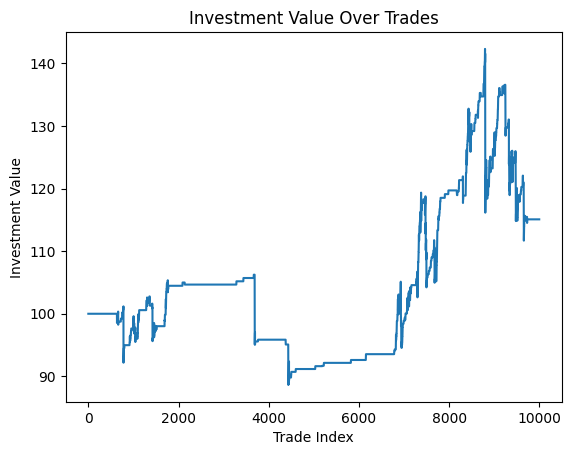

In [ ]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
GAIN = 0.5  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # A "bad" (wrong) trade
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = validation_dataset["LTCUSDT:close9"][idx + 1]
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}")
print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{PREDICTOR}{EPOCHS - 1}"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
# Analysis of returns made by trading strategy

MINIMUM_PROBABILITY = 0.8
LEVERAGE = 5
GAIN = 0.5

CORRECT = 0
NUM_TRADES = 0
BAD_TRADES = []
ALL_TRADES = []
invested = 100
invested_list = []

for index, probbb in enumerate(validation_probabilities[1].to_list()):

    # IF THE PREDICTION HAS A SUFFICIENT PROBABILITY
    if probbb >= MINIMUM_PROBABILITY:
        NUM_TRADES += 1

        # IF THE PREDICTION IS CORRECT
        if validation_predictions["Label"][index] == validation_dataset["Label"][index]:
            CORRECT += 1
            ALL_TRADES.append(GAIN * LEVERAGE)
            invested *= 1 + (GAIN / 100 * LEVERAGE)
            copyy = invested
            invested_list.append(copyy)

        # IF THE PREDICTION IS INCORRECT    
        else:
            true_close = validation_dataset["LTCUSDT:close4"][index + 1]
            bad_trad = (round(true_close * LEVERAGE, 3), round(probbb, 3))
            BAD_TRADES.append(bad_trad)
            ALL_TRADES.append(true_close * LEVERAGE)
            invested *= 1 + (true_close/ 100 * LEVERAGE)
            copyy = invested
            invested_list.append(copyy)

    else:
        copyy = invested
        invested_list.append(copyy)



print(f"CORRECT: {CORRECT}")
print(f"WRONG: {NUM_TRADES - CORRECT}")
print(f"NUMBER OF TRADES: {NUM_TRADES}")
print(f"WINRATE: {round(CORRECT / NUM_TRADES, 3) * 100}%")
print(f"RETURN: {round(invested - 100, 3)} %")
print(f"IVESTMENT VALUE: {invested}")
print("----------------------------------")
for btbb in BAD_TRADES:
    print(btbb)


from matplotlib import pyplot as plt

plt.plot(invested_list)
plt.show()




In [ ]:
##################### PROBABILITY ANALYSIS AND EXPECTED RETURNS
################# Probability analysis ###########################
import statistics as st

# Minimum required confidence for executing a trade
PROB_THRESH = 0.8
LEVERAGE = 5

# display(test_tabular_dataset)
# display(test_data_frame2[LABEL][len(labelled_data_frame) - VALIDATION_SIZE])


y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))
# display(y_prob)

counter = 0
correct = 0

predicted_high_list = []
predicted_low_list = []
predicted_close_list = []

balance = 100

hour_count = 0
month_gain = []
month = 100


first_index_dataset = len(labelled_data_frame) - VALIDATION_SIZE

print("------------------- TRADES: ------------------------------")
for index, pred in enumerate(y_pred):
    try:
        index = index + first_index_dataset
        prob = y_prob[1][index]
        actual = testing_dataframe["Label"][index]

        true_high = testing_dataframe["LTCUSDT:high4"][index + 1]
        true_low = testing_dataframe["LTCUSDT:low4"][index + 1]
        true_close = testing_dataframe["LTCUSDT:close4"][index + 1]
        

        if prob > PROB_THRESH:
            counter += 1

            if pred == 1 and actual == 1:
                correct += 1
                predicted_high_list.append(true_high)
                predicted_low_list.append(true_low)
                predicted_close_list.append(true_close)

            ### LOGIC FOR CALCULATING GAIN ###
            if true_high >= 0.5:
                balance *= 1 + (0.005 * LEVERAGE)
                month *= 1 + (0.005 * LEVERAGE)
                print(f"{index}. Gain +5%")
            else:
                balance *= 1 + ((true_close / 100) * LEVERAGE)
                month *= 1 + ((true_close / 100) * LEVERAGE)
                #print(f"{index}. Close + {true_close} ---> High: {true_high}, Low: {true_low}, Close: {true_close}")
                print(f"{index}. Close +{true_close * LEVERAGE}")
    
        hour_count += 1
        if hour_count == 730:
            hour_count = 0
            month_gain.append(round(month - 100, 3))
            month = 100

    except Exception as e:
        print(f"Got following error: {e}")


month_gain.append(month - 100)

        

print("------------------------------------------")
print(f"Correct: {correct}")
print(f"Counter: {counter}")
print(f"Winrate: {correct / counter}")

print(f"AVG High: {st.mean(predicted_high_list)}")
print(f"AVG Low: {st.mean(predicted_low_list)}")
print(f"AVG Close: {st.mean(predicted_close_list)}")
print()
print(f"Balance: {balance}")
print(f"Return: {balance - 100}%")
print()
print(f"Month List: {month_gain}")
print(f"Mean month gain: {st.mean(month_gain)}")

CORRECT: 40
WRONG: 126
NUMBER OF TRADES: 166
WIN RATE: 24.1%
----------------------------------
MEAN GOOD TRADES: 1.5982868460239368
MEAN BAD TRADES: -1.6207912834529672
INVESTMENT VALUE 23.498981883823074


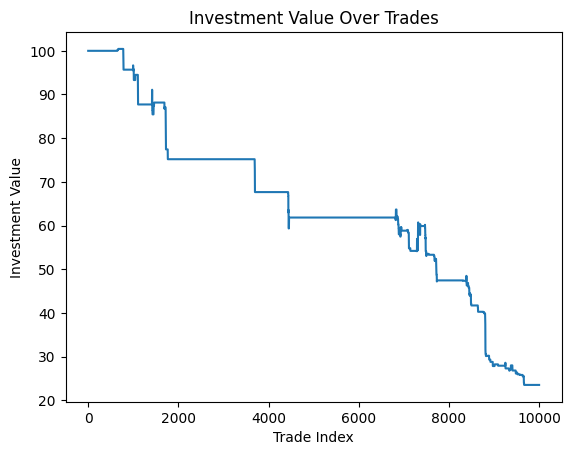

In [9]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0.25:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")
print(f"INVESTMENT VALUE {investment_value}")

# investtt = 100
# investment_history2 = []
# for trade in all_trades:
#     investtt *= 1 + (trade / 100)
#     investment_history2.append(investtt)
#     # print(trade)

# print(f"RETURN: {round(investtt - 100, 3)} %")


from matplotlib import pyplot as plt
# --- Plot the investment history ---
plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()